<a href="https://colab.research.google.com/github/Strojove-uceni/2024-final-michal-aaron/blob/main/wildfire_spread_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Wildfire Spread Prediction

*Autor: Michal Bohatý*

*Abstrakt*:

Lesní požáry jsou jednním z přírodních jevů, se kterými se lidstvo musí každoročně vypořádávat. V porovnání s jinými katastorfami naštěstí patří k těm méně nebezpečným, přesto si každoročně vyžádají stovky lidských životů a způsobí nezanedbatelné škody na majetku. Předpověď jejich šíření může být tedy klíčovou pro minimalizci jejich následků. V současnosti máme k dispozici stále více dat z dálkového průzkumu Země, které k tomuto účelu můžeme použít. Cílem tohoto projektu bylo vytvořit model, který dokáže predikovat vývoj požáru na základě satelitních dat z předchozího dne. Pro predikce jsme použili neuronovou síť typu U-Net, podařilo se nám ale dosáhnout pouze omezených výsledků, pravděpodobně zejména kvůli relativně malému rozlišení satelitních dat a možným dlouhodobějším závislostem.



###Dataset

Pro trénování a validaci modelu používáme dataset [Next Day Wildfire Spread](https://www.kaggle.com/datasets/fantineh/next-day-wildfire-spread/data), který obsahuje data z let 2012 až 2020 z USA. Dataset čítá celkem 18 445 vzorků, každý z nich zachycuje oblast o rozloze 64 km × 64 km s rozlišením 1 km. Pro každou oblast máme k dispozici tyto informace:


*   maska výskytu požáru v aktuálním dni,
*   maska výskytu požáru v následujícím dni,
*   výškový profil oblasti,
*   směr větru,
*   rychlost větru,
*   minimální teplota,
*   maximální teplota,
*   vlhkost,
*   srážky,
*   index sucha,
*   vegetace (normalizovaný rozdílový vegetační index – NDVI),
*   hustota zalidnění,
*   energetická uvolňovací složka – ERC (množství energie, která se může uvolnit hořením)

Masky požáru mohou obsahovat obsahovat hodnoty:

* 0 = žádný požár
* 1 = požár
* -1 = nelze klasifikovat (např. kvůli oblačnosti)

Náš model bude klasifikovat pouze do dvou tříd (0 a 1), při vyhodnocování tedy přiřadíme neklasifikované pixely do skupiny 0. Ukázka dat je na obrázku níže.



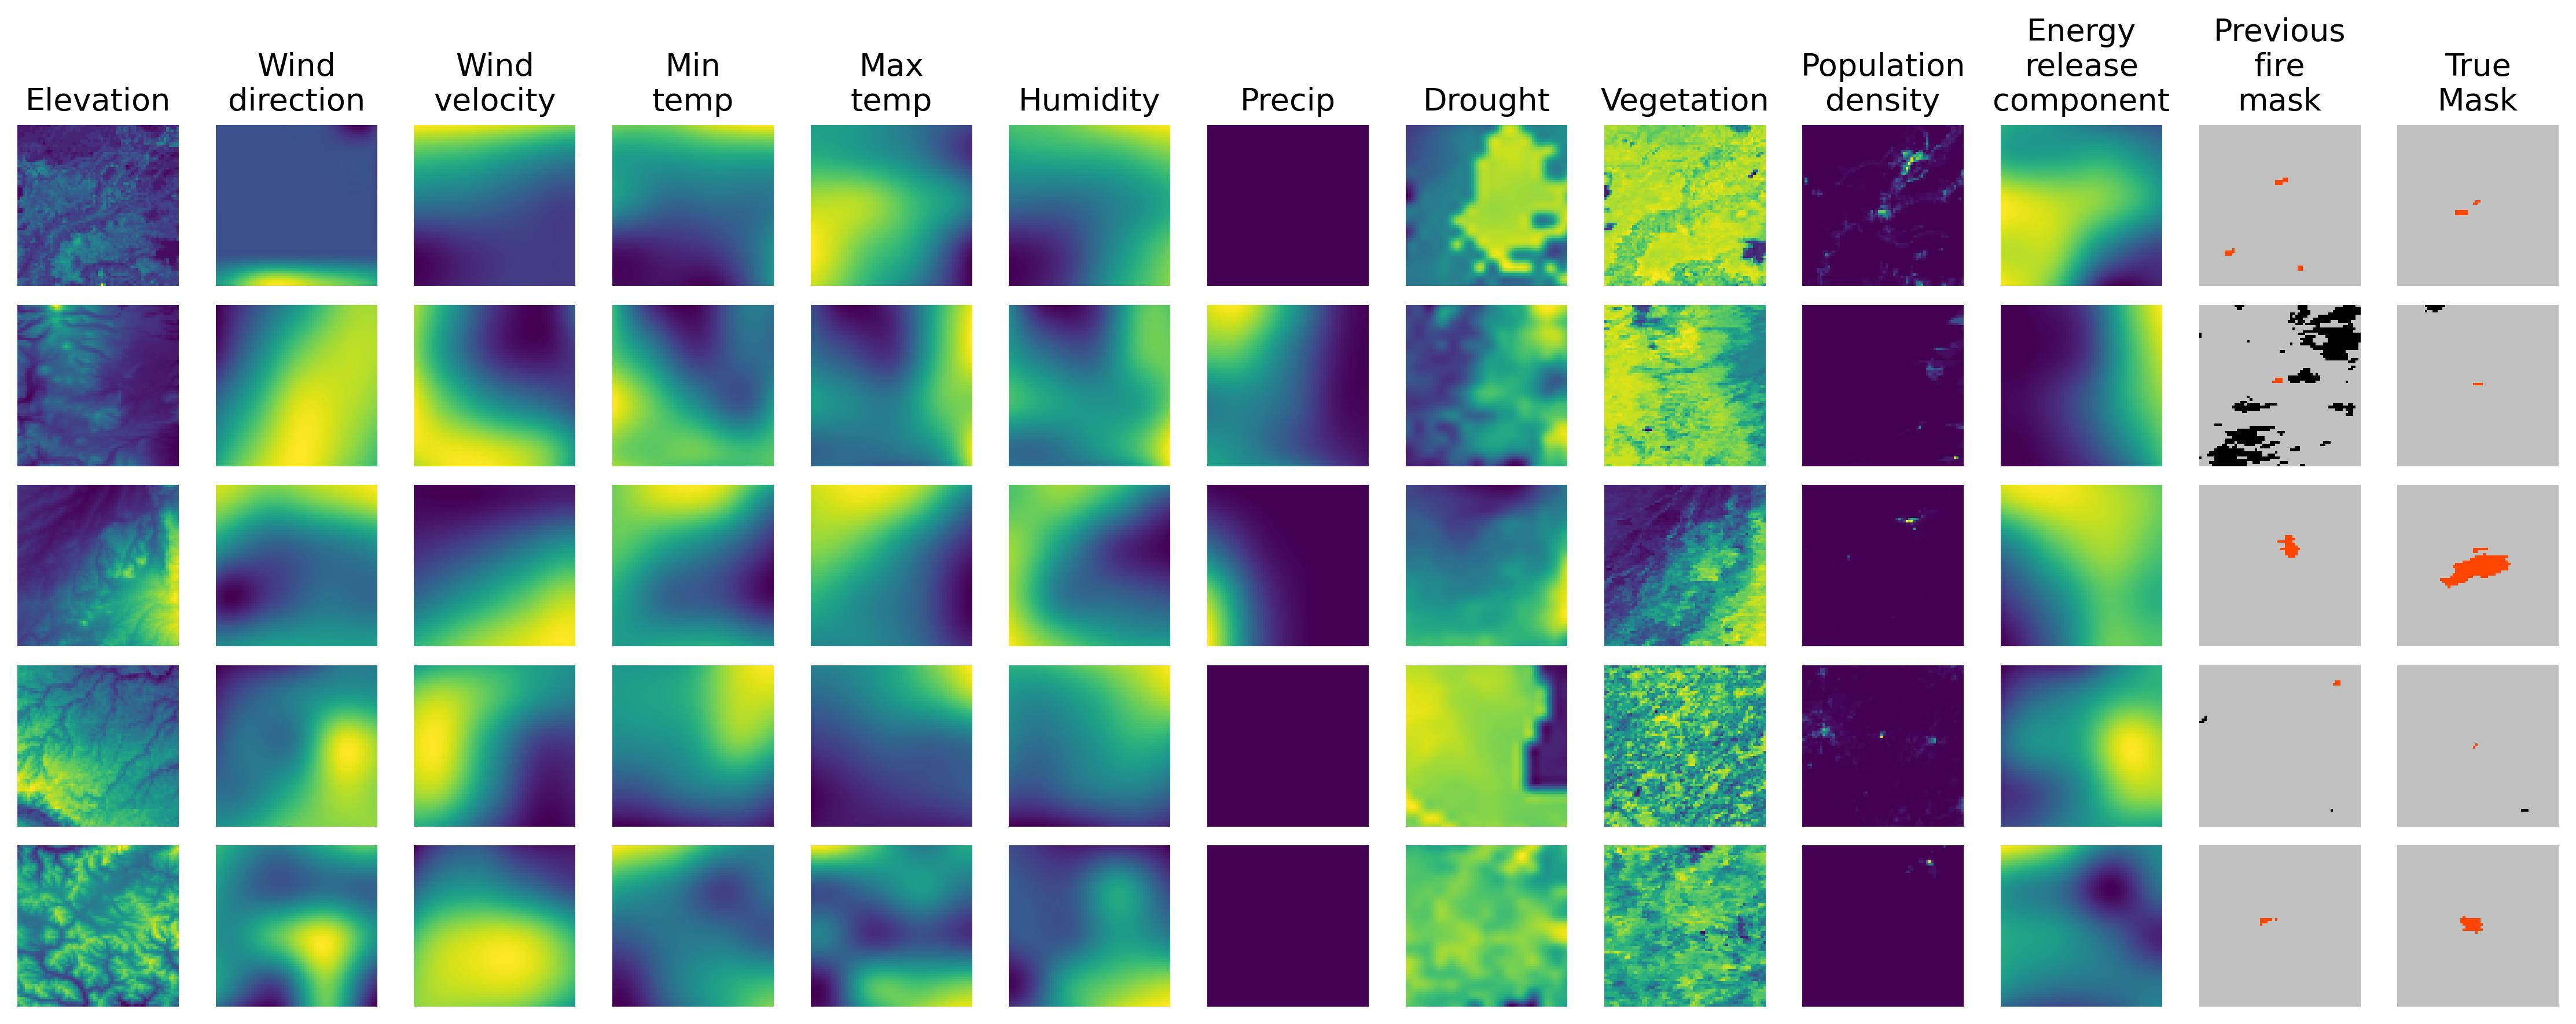


Pro náš účel mají data jednu chybu, a to že jsou většinou centrovaná kolem požárů, které se snažíme predikovat. Z tohoto důvodu používáme náhodné ořezávání dat vstupujících do modelu na velikost 32x32.

### Architektura modelu

Protože naším cílem je segmentace obrazu (predikce binární masky), používáme neuronovou síť typu U-Net se skip-connections. Na každé její úrovní jsou dvě konvoluční vrstvy s jádrem 3x3. Jelikož nechceme, aby nám konvoluce snižovaly rozlišení, používáme zero-padding.

| **Název vrstvy**     | **Vstupní kanály** | **Výstupní kanály** | **Rozlišení** | **Popis**                                                                            |
|-----------------------|--------------------|---------------------|---------------|--------------------------------------------------------------------------------------|
| **Vstupní vrstva**    | 12                | 64                  | 32x32         | Dvojitá konvoluce s 3x3 jádrem a paddingem.                  |
| **První vrstva encoderu**| 64                | 128                 | 16x16         | Max-pooling, dvojitá konvoluce. |
| **Druhá vrstva encoderu**| 128               | 256                 | 8x8           | Max-pooling, dvojitá konvoluce.                           |
| **Bottleneck**        | 256               | 512                 | 4x4           | Max-pooling, dvojitá konvoluce.                                   |
| **První vrstva decoderu**| 512               | 256                 | 8x8           | Upsampling pomocí transponované konvoluce, přidání skip connections, dvojitá konvoluce. |
| **Druhá vrstva decoderu**| 256               | 128                 | 16x16         | Upsampling, přidání skip connections, dvojitá konvoluce. |
| **Výstupní vrstva**   | 128               | 64                  | 32x32         | Upsampling, přidání skip connections, dvojitá konvoluce.               |
| **Finální výstup**    | 64                | 1                   | 32x32         | Poslední konvoluční vrstva, produkuje logity pro výstupní masku. |


##Načtení potřebných balíčků a souborů

Pokud budete chtít tento notebook spouštět a vyskoušet si fungování modelu, přidejte si tuto složku na váš google disk: https://drive.google.com/drive/folders/1RwHY9O-wtmivHxXTsdG7lVcnrogIhHzE?usp=sharing


Tato složka obsahuje všechna potřebná data a uložený checkpoint natrénovaného modelu.

Nyní postupně nainstalujeme a načteme potřebné balíčky a připojíme google disk k notebooku.

In [ ]:
%pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 42.5 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
import torch.nn.functional as F
import pytorch_lightning as pl
from torch.utils.data import DataLoader, IterableDataset, Dataset
from torchmetrics.classification import BinaryPrecision, BinaryRecall
from torchvision.transforms.v2 import Compose, RandomCrop, CenterCrop, RandomHorizontalFlip, RandomRotation

from pytorch_lightning.loggers.wandb import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
import wandb

import tensorflow as tf
import re
from typing import Dict, List, Optional, Text, Tuple
import random

import os
from google.colab import drive

import matplotlib.pyplot as plt
from matplotlib import colors

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_files = '/content/drive/MyDrive/SU2/data/next_day_wildfire_spread_train*'
eval_files = '/content/drive/MyDrive/SU2/data/next_day_wildfire_spread_eval*'
test_files = '/content/drive/MyDrive/SU2/data/next_day_wildfire_spread_test*'

##Knihovna pro načtení a předzpracování dat

Následujících několik buněk obsahuje kód od autorů datasetu. Jsou v něm funkce potřebné pro načtení a předzpracování dat. První buňka obsahuje názvy jednotlivých proměnných a statistiky pro jejich normalizaci.

In [ ]:
"""Constants for the data reader."""

INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph',
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']

OUTPUT_FEATURES = ['FireMask', ]

# Data statistics
# For each variable, the statistics are ordered in the form:
# (min_clip, max_clip, mean, standard deviation)
DATA_STATS = {
    # Elevation in m.
    # 0.1 percentile, 99.9 percentile
    'elevation': (0.0, 3141.0, 657.3003, 649.0147),
    # Pressure
    # 0.1 percentile, 99.9 percentile
    'pdsi': (-6.12974870967865, 7.876040384292651, -0.0052714925, 2.6823447),
    'NDVI': (-9821.0, 9996.0, 5157.625, 2466.6677),  # min, max
    # Precipitation in mm.
    # Negative values do not make sense, so min is set to 0.
    # 0., 99.9 percentile
    'pr': (0.0, 44.53038024902344, 1.7398051, 4.482833),
    # Specific humidity.
    # Negative values do not make sense, so min is set to 0.
    # The range of specific humidity is up to 100% so max is 1.
    'sph': (0., 1., 0.0071658953, 0.0042835088),
    # Wind direction in degrees clockwise from north.
    # Thus min set to 0 and max set to 360.
    'th': (0., 360.0, 190.32976, 72.59854),
    # Min/max temperature in Kelvin.
    # -20 degree C, 99.9 percentile
    'tmmn': (253.15, 298.94891357421875, 281.08768, 8.982386),
    # -20 degree C, 99.9 percentile
    'tmmx': (253.15, 315.09228515625, 295.17383, 9.815496),
    # Wind speed in m/s.
    # Negative values do not make sense, given there is a wind direction.
    # 0., 99.9 percentile
    'vs': (0.0, 10.024310074806237, 3.8500874, 1.4109988),
    # NFDRS fire danger index energy release component expressed in BTU's per
    # square foot.
    # Negative values do not make sense. Thus min set to zero.
    # 0., 99.9 percentile
    'erc': (0.0, 106.24891662597656, 37.326267, 20.846027),
    # Population density
    # min, 99.9 percentile
    'population': (0., 2534.06298828125, 25.531384, 154.72331),
    # We don't want to normalize the FireMasks.
    # 1 indicates fire, 0 no fire, -1 unlabeled data
    'PrevFireMask': (-1., 1., 0., 1.),
    'FireMask': (-1., 1., 0., 1.)
}

Tato buňka zavádí funkce pro ořezávání dat.

In [ ]:
"""Library of common functions used in deep learning neural networks.
"""
def random_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
    num_in_channels: int,
    num_out_channels: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Randomly axis-align crop input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
    num_in_channels: number of channels in input_img.
    num_out_channels: number of channels in output_img.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  combined = tf.concat([input_img, output_img], axis=2)
  combined = tf.image.random_crop(
      combined,
      [sample_size, sample_size, num_in_channels + num_out_channels])
  input_img = combined[:, :, 0:num_in_channels]
  output_img = combined[:, :, -num_out_channels:]
  return input_img, output_img


def center_crop_input_and_output_images(
    input_img: tf.Tensor,
    output_img: tf.Tensor,
    sample_size: int,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Center crops input and output image tensors.

  Args:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
    sample_size: side length (square) to crop to.
  Returns:
    input_img: tensor with dimensions HWC.
    output_img: tensor with dimensions HWC.
  """
  central_fraction = sample_size / input_img.shape[0]
  input_img = tf.image.central_crop(input_img, central_fraction)
  output_img = tf.image.central_crop(output_img, central_fraction)
  return input_img, output_img

Dále definujeme samotné načítání datasetu do TensorFlow datasetu. Oproti původnímu kódu byla změněna pouze funkce get_dataset() tak, aby vracela dataset, který neobsahuje batche.

In [ ]:
"""Dataset reader for Earth Engine data."""

def _get_base_key(key: Text) -> Text:
  """Extracts the base key from the provided key.

  Earth Engine exports TFRecords containing each data variable with its
  corresponding variable name. In the case of time sequences, the name of the
  data variable is of the form 'variable_1', 'variable_2', ..., 'variable_n',
  where 'variable' is the name of the variable, and n the number of elements
  in the time sequence. Extracting the base key ensures that each step of the
  time sequence goes through the same normalization steps.
  The base key obeys the following naming pattern: '([a-zA-Z]+)'
  For instance, for an input key 'variable_1', this function returns 'variable'.
  For an input key 'variable', this function simply returns 'variable'.

  Args:
    key: Input key.

  Returns:
    The corresponding base key.

  Raises:
    ValueError when `key` does not match the expected pattern.
  """
  match = re.match(r'([a-zA-Z]+)', key)
  if match:
    return match.group(1)
  raise ValueError(
      'The provided key does not match the expected pattern: {}'.format(key))


def _clip_and_rescale(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and rescales inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and rescale.
    key: Key describing the inputs.

  Returns:
    Clipped and rescaled input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, _, _ = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  return tf.math.divide_no_nan((inputs - min_val), (max_val - min_val))


def _clip_and_normalize(inputs: tf.Tensor, key: Text) -> tf.Tensor:
  """Clips and normalizes inputs with the stats corresponding to `key`.

  Args:
    inputs: Inputs to clip and normalize.
    key: Key describing the inputs.

  Returns:
    Clipped and normalized input.

  Raises:
    ValueError if there are no data statistics available for `key`.
  """
  base_key = _get_base_key(key)
  if base_key not in DATA_STATS:
    raise ValueError(
        'No data statistics available for the requested key: {}.'.format(key))
  min_val, max_val, mean, std = DATA_STATS[base_key]
  inputs = tf.clip_by_value(inputs, min_val, max_val)
  inputs = inputs - mean
  return tf.math.divide_no_nan(inputs, std)

def _get_features_dict(
    sample_size: int,
    features: List[Text],
) -> Dict[Text, tf.io.FixedLenFeature]:
  """Creates a features dictionary for TensorFlow IO.

  Args:
    sample_size: Size of the input tiles (square).
    features: List of feature names.

  Returns:
    A features dictionary for TensorFlow IO.
  """
  sample_shape = [sample_size, sample_size]
  features = set(features)
  columns = [
      tf.io.FixedLenFeature(shape=sample_shape, dtype=tf.float32)
      for _ in features
  ]
  return dict(zip(features, columns))


def _parse_fn(
    example_proto: tf.train.Example, data_size: int, sample_size: int,
    num_in_channels: int, clip_and_normalize: bool,
    clip_and_rescale: bool, random_crop: bool, center_crop: bool,
) -> Tuple[tf.Tensor, tf.Tensor]:
  """Reads a serialized example.

  Args:
    example_proto: A TensorFlow example protobuf.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    num_in_channels: Number of input channels.
    clip_and_normalize: True if the data should be clipped and normalized.
    clip_and_rescale: True if the data should be clipped and rescaled.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data should be cropped in the center.

  Returns:
    (input_img, output_img) tuple of inputs and outputs to the ML model.
  """
  if (random_crop and center_crop):
    raise ValueError('Cannot have both random_crop and center_crop be True')
  input_features, output_features = INPUT_FEATURES, OUTPUT_FEATURES
  feature_names = input_features + output_features
  features_dict = _get_features_dict(data_size, feature_names)
  features = tf.io.parse_single_example(example_proto, features_dict)

  if clip_and_normalize:
    inputs_list = [
        _clip_and_normalize(features.get(key), key) for key in input_features
    ]
  elif clip_and_rescale:
    inputs_list = [
        _clip_and_rescale(features.get(key), key) for key in input_features
    ]
  else:
    inputs_list = [features.get(key) for key in input_features]

  inputs_stacked = tf.stack(inputs_list, axis=0)
  input_img = tf.transpose(inputs_stacked, [1, 2, 0])

  outputs_list = [features.get(key) for key in output_features]
  assert outputs_list, 'outputs_list should not be empty'
  outputs_stacked = tf.stack(outputs_list, axis=0)

  outputs_stacked_shape = outputs_stacked.get_shape().as_list()
  assert len(outputs_stacked.shape) == 3, ('outputs_stacked should be rank 3'
                                            'but dimensions of outputs_stacked'
                                            f' are {outputs_stacked_shape}')
  output_img = tf.transpose(outputs_stacked, [1, 2, 0])

  if random_crop:
    input_img, output_img = random_crop_input_and_output_images(
        input_img, output_img, sample_size, num_in_channels, 1)
  if center_crop:
    input_img, output_img = center_crop_input_and_output_images(
        input_img, output_img, sample_size)
  return input_img, output_img


def get_dataset(file_pattern: Text, data_size: int, sample_size: int,
                num_in_channels: int, compression_type: Text,
                clip_and_normalize: bool, clip_and_rescale: bool,
                random_crop: bool, center_crop: bool) -> tf.data.Dataset:
  """Gets the dataset from the file pattern.

  Args:
    file_pattern: Input file pattern.
    data_size: Size of tiles (square) as read from input files.
    sample_size: Size the tiles (square) when input into the model.
    batch_size: Batch size.
    num_in_channels: Number of input channels.
    compression_type: Type of compression used for the input files.
    clip_and_normalize: True if the data should be clipped and normalized, False
      otherwise.
    clip_and_rescale: True if the data should be clipped and rescaled, False
      otherwise.
    random_crop: True if the data should be randomly cropped.
    center_crop: True if the data shoulde be cropped in the center.

  Returns:
    A TensorFlow dataset loaded from the input file pattern, with features
    described in the constants, and with the shapes determined from the input
    parameters to this function.
  """
  if (clip_and_normalize and clip_and_rescale):
    raise ValueError('Cannot have both normalize and rescale.')
  dataset = tf.data.Dataset.list_files(file_pattern)
  dataset = dataset.interleave(
      lambda x: tf.data.TFRecordDataset(x, compression_type=compression_type),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  dataset = dataset.map(
      lambda x: _parse_fn(  # pylint: disable=g-long-lambda
          x, data_size, sample_size, num_in_channels, clip_and_normalize,
          clip_and_rescale, random_crop, center_crop),
      num_parallel_calls=tf.data.experimental.AUTOTUNE)
  #dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

##Definice modelu

Nyní přistupme k samotnému modelu, který budeme pro predikce používat. Bude se jednat o síť typu [U-Net](https://link.springer.com/chapter/10.1007/978-3-319-24574-4_28).

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels, dropout):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout),
        )

    def forward(self, x):
        return self.conv(x)

# Define U-Net model
class UNET(nn.Module):
    def __init__(self, in_channels=12, out_channels=1, features=[64, 128, 256], dropout=0.0):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down-sampling layers
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature, dropout))
            in_channels = feature

        # Up-sampling layers
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature * 2, feature, dropout))

        # Bottleneck layer
        self.bottleneck = DoubleConv(features[-1], features[-1] * 2, dropout)

        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        # Pass through the down-sampling layers
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        # Bottleneck
        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        # Pass through the up-sampling layers
        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]

            # Resize if shapes do not match
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            # Concatenate with skip connection
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx + 1](concat_skip)

        # Final convolution and sigmoid activation
        return self.final_conv(x)

Jako ztrátovou funci budeme používat dice loss.

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        # Flatten tensors to compute intersection and union
        preds = preds.view(-1)
        targets = targets.view(-1)

        # Compute intersection and union
        intersection = (preds * targets).sum()
        dice_coeff = (2. * intersection + self.smooth) / (preds.sum() + targets.sum() + self.smooth)

        # Return Dice loss (1 - Dice coefficient)
        return 1 - dice_coeff

Nyní už můžeme sestavit samotný pytorch ligthning modul.

In [ ]:
class UNETLightning(pl.LightningModule):
    def __init__(self, in_channels=12, out_channels=1, features=[128, 256, 512], threshold=0.5, learning_rate=1e-3, dropout=0.0):
        """
        PyTorch Lightning wrapper for U-Net.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            features (list): List of feature sizes for the encoder/decoder.
            threshold (float): Threshold for binary segmentation.
            learning_rate (float): Learning rate for the optimizer.
        """
        super(UNETLightning, self).__init__()
        self.save_hyperparameters()  # Save hyperparameters for logging and reproducibility
        self.unet = UNET(in_channels=in_channels, out_channels=out_channels, features=features, dropout=dropout)
        self.loss_fn = DiceLoss()  # Use Binary Cross-Entropy Loss
        self.precision = BinaryPrecision(threshold=threshold)
        self.recall = BinaryRecall(threshold=threshold)
        self.threshold = threshold
        self.learning_rate = learning_rate

    def forward(self, x):
        # Pass through U-Net
        return self.unet(x)

    def _shared_step(self, batch, stage):
        x, y = batch
        preds = torch.sigmoid(self(x))
        # Calculate loss
        #print(preds.shape, y.shape)
        loss = self.loss_fn(preds, y)

        # Calculate precision and recall
        precision = self.precision(preds, y)
        recall = self.recall(preds, y)

        # Log metrics
        self.log(f"{stage}_loss", loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log(f"{stage}_precision", precision, prog_bar=True, on_epoch=True, on_step=False)
        self.log(f"{stage}_recall", recall, prog_bar=True, on_epoch=True, on_step=False)

        return loss

    def training_step(self, batch, batch_idx):
        return self._shared_step(batch, stage="train")

    def validation_step(self, batch, batch_idx):
        return self._shared_step(batch, stage="val")

    def test_step(self, batch, batch_idx):
        return self._shared_step(batch, stage="test")

    def configure_optimizers(self):
        # Use the configurable learning rate
        optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        return optimizer

Data modul

In [ ]:
class FireDataset(Dataset):
    def __init__(self, tf_dataset, transform=None):
        self.tf_dataset = list(tf_dataset)
        self.crop_size = crop_size
        self.transform = transform

    def __len__(self):
        return len(self.tf_dataset)

    def __getitem__(self, idx):
        x, y = self.tf_dataset[idx]
        x = tf.convert_to_tensor(x).numpy()
        y = tf.convert_to_tensor(y).numpy()

        # Convert to PyTorch tensors and permute to CHW
        x = torch.tensor(x, dtype=torch.float32).permute(2, 0, 1)  # HWC -> CHW
        y = torch.tensor(y, dtype=torch.float32).permute(2, 0, 1)

        # Transform -1 in y to 0
        y = torch.where(y == -1, torch.tensor(0.0, device=y.device), y)

        if self.transform:
            stacked = torch.cat((x, y), dim=0)  # Combine x and y for joint transform
            stacked = self.transform(stacked)
            x, y = stacked[:x.shape[0]], stacked[x.shape[0]:]  # Split back into x and y

        return x, y


class FireDataModule(pl.LightningDataModule):
    def __init__(self, train_dataset, test_dataset, eval_dataset, crop_size=64, batch_size=32):
        """
        PyTorch Lightning DataModule for fire data.

        Args:
            train_dataset: TensorFlow dataset for training.
            test_dataset: TensorFlow dataset for testing.
            eval_dataset: TensorFlow dataset for evaluation.
            batch_size: Batch size for DataLoader.
        """
        super().__init__()
        self.train_dataset = train_dataset
        self.test_dataset = test_dataset
        self.eval_dataset = eval_dataset
        self.batch_size = batch_size
        self.crop_size = crop_size

        self.train_transform = Compose([
          RandomCrop(self.crop_size),
          #RandomHorizontalFlip(p=0.5),
        ])
        self.test_transform = Compose([
          CenterCrop(self.crop_size),
        ])

    def setup(self, stage=None):
        """
        Setup datasets for training, validation, and testing.

        Args:
            stage: Current stage (e.g., 'fit', 'test').
        """
        # Convert TensorFlow datasets to PyTorch-compatible datasets
        self.train_data = FireDataset(self.train_dataset, transform=self.train_transform)
        self.test_data = FireDataset(self.test_dataset, transform=self.test_transform)
        self.eval_data = FireDataset(self.eval_dataset, transform=self.test_transform)

    def train_dataloader(self):
        """Returns the DataLoader for training."""
        return DataLoader(self.train_data, batch_size=self.batch_size, shuffle=True)

    def test_dataloader(self):
        """Returns the DataLoader for testing."""
        return DataLoader(self.test_data, batch_size=self.batch_size)

    def val_dataloader(self):
        """Returns the DataLoader for evaluation."""
        return DataLoader(self.eval_data, batch_size=self.batch_size)

##Načtení datasetu

In [ ]:
"""train_dataset = get_dataset(
      train_files,
      data_size=64,
      sample_size=64,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

eval_dataset = get_dataset(
      eval_files,
      data_size=64,
      sample_size=64,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)"""

test_dataset = get_dataset(
      test_files,
      data_size=64,
      sample_size=64,
      num_in_channels=12,
      compression_type=None,
      clip_and_normalize=True,
      clip_and_rescale=False,
      random_crop=True,
      center_crop=False)

In [ ]:
#print(f"Train dataset size: {len(list(train_dataset))}")
#print(f"Eval dataset size: {len(list(eval_dataset))}")
print(f"Test dataset size: {len(list(test_dataset))}")

Train dataset size: 14979
Eval dataset size: 1877
Test dataset size: 1689


##Načtení natrénovaného modelu

In [ ]:
#hyperparameters
batch_size = 16
crop_size = 64
learning_rate = 1e-3
dropout = 0.0
features = [64, 128, 256, 512]

model = UNETLightning(features=features, threshold = 0.5, learning_rate=learning_rate, dropout=dropout)
data_module = FireDataModule(train_dataset=train_dataset, test_dataset=test_dataset, eval_dataset=eval_dataset, crop_size=crop_size, batch_size=batch_size)

model = UNETLightning.load_from_checkpoint("/content/drive/MyDrive/SU2/unet-epoch=11-val_loss=0.64.ckpt")
model.eval()

UNETLightning(
  (unet): UNET(
    (ups): ModuleList(
      (0): ConvTranspose2d(1024, 512, kernel_size=(2, 2), stride=(2, 2))
      (1): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Dropout(p=0.0, inplace=False)
          (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (6): ReLU(inplace=True)
          (7): Dropout(p=0.0, inplace=False)
        )
      )
      (2): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
      (3): DoubleConv(
        (conv): Sequential(
          (0): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_runni

In [ ]:
dataset_iter = iter(test_dataset)

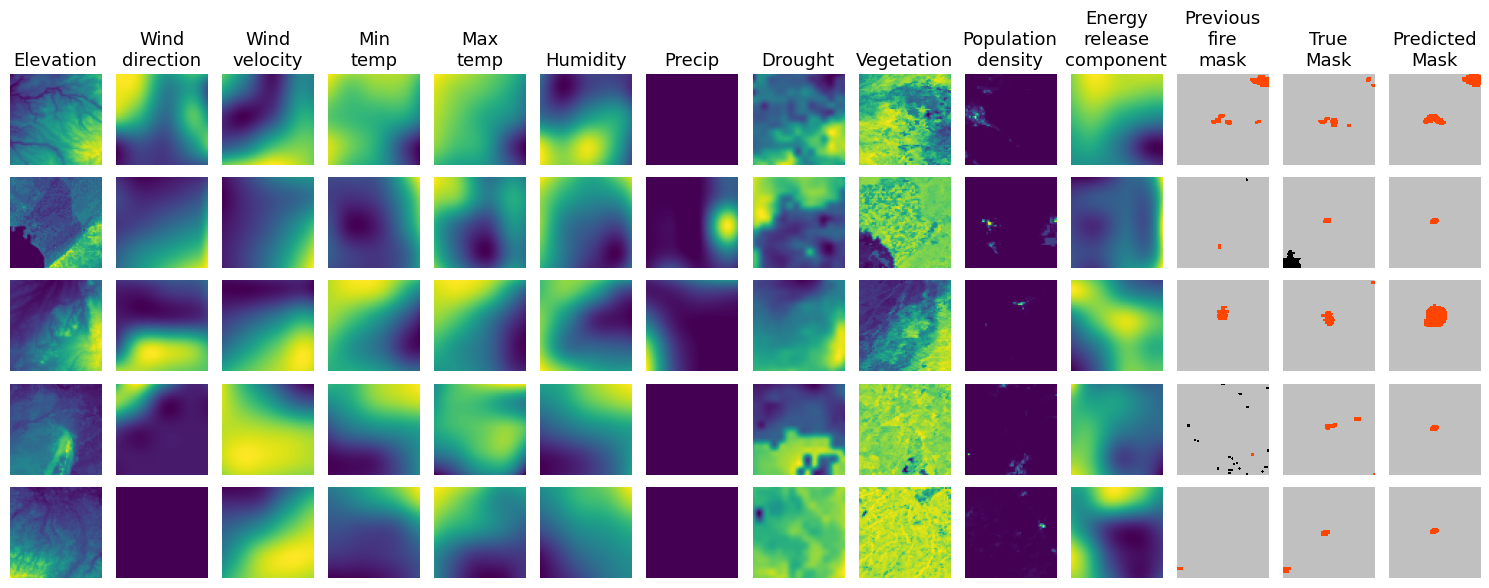

In [ ]:
NUM_EXAMPLES = 5  # Number of examples to visualize

# Define constants for visualization
TITLES = [
    'Elevation', 'Wind\ndirection', 'Wind\nvelocity', 'Min\ntemp', 'Max\ntemp',
    'Humidity', 'Precip', 'Drought', 'Vegetation', 'Population\ndensity',
    'Energy\nrelease\ncomponent', 'Previous\nfire\nmask', 'Fire\nmask'
]
CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
BOUNDS = [-1, -0.1, 0.001, 1]
NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)

# Fetch data (unbatched)
examples = [next(dataset_iter) for i in range(NUM_EXAMPLES)]  # Collect NUM_EXAMPLES individual examples
inputs = torch.stack([torch.tensor(example[0].numpy(), dtype=torch.float32).permute(2, 0, 1) for example in examples])  # Convert and stack inputs
labels = torch.stack([torch.tensor(example[1].numpy(), dtype=torch.float32).permute(2, 0, 1) for example in examples])  # Convert and stack labels

# Move model and inputs to the same device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = inputs.to(device)
labels = labels.to(device)

# Generate predictions
predictions = []
for i in range(NUM_EXAMPLES):
  inputs_i = inputs[i].unsqueeze(0)  # Add batch dimension
  with torch.no_grad():
      predictions.append((model(inputs_i) > 0.5).float())  # Apply sigmoid activation

# Visualize results
fig = plt.figure(figsize=(15, 6))
predictions = torch.cat(predictions, dim=0)  # Stack predictions for visualization

for i in range(NUM_EXAMPLES):
    for j in range(inputs.shape[1] + 2):  # Including labels and predictions
        plt.subplot(NUM_EXAMPLES, inputs.shape[1] + 2, i * (inputs.shape[1] + 2) + j + 1)
        if i == 0:
            if j < inputs.shape[1]:
                plt.title(TITLES[j], fontsize=13)
            elif j == inputs.shape[1]:
                plt.title("True\nMask", fontsize=13)
            else:
                plt.title("Predicted\nMask", fontsize=13)

        if j < inputs.shape[1] - 1:
            # Visualization for input features
            plt.imshow(inputs[i, j, :, :].cpu().numpy(), cmap='viridis')
        elif j == inputs.shape[1] - 1:
            # Visualization for input fire mask
            plt.imshow(inputs[i, j, :, :].cpu().numpy(), cmap=CMAP, norm=NORM)
        elif j == inputs.shape[1]:
            # Visualization for true mask (labels)
            plt.imshow(labels[i, 0, :, :].cpu().numpy(), cmap=CMAP, norm=NORM)
        else:
            # Visualization for predicted mask
            plt.imshow(predictions[i, 0, :, :].cpu().numpy(), cmap=CMAP, norm=NORM)
        plt.axis('off')

plt.tight_layout()
plt.show()